In [1]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, cv2, glob

## **Base Model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
img_folder = '/content/drive/My Drive/Colab Notebooks/Matuschkalulu/traffic_signs/raw_data/Train'

Mounted at /content/drive


In [3]:
def create_dataset(img_folder):
    classes={(img_folder + 'recognizable'):0, (img_folder + 'unrecognizable'):1}

    img_data_array=[]
    class_name=[]
    IMG_WIDTH=224
    IMG_HEIGHT=224
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):

            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [4]:
img_data, class_name= create_dataset(img_folder)

In [5]:
X = img_data
y = class_name
X, y = shuffle(X, y)
X= np.array(X)
y= np.array(y)

In [6]:
train_size= int(len(X) *0.60)
val_size= train_size + int(len(X) * 0.20)

X_train= X[:train_size]
y_train= y[:train_size]

X_val= X[train_size:val_size]
y_val= y[train_size:val_size]

X_test= X[val_size:]
y_test= y[val_size:]

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((327, 224, 224, 3),
 (327,),
 (109, 224, 224, 3),
 (109,),
 (110, 224, 224, 3),
 (110,))

In [8]:
X_train_preproc= preprocess_input(X_train).astype('float')
X_val_preproc= preprocess_input(X_val).astype('float')
X_test_preproc= preprocess_input(X_test).astype('float')

y_train= y_train.astype('float')
y_val= y_val.astype('float')
y_test= y_test.astype('float')

In [9]:
def vgg_base_model():
  base_model= VGG16(weights='imagenet', input_shape=X_train[0,:,:].shape, include_top=False)
  base_model.trainable=False
  last_layer= base_model.output

  x= Flatten()(last_layer)
  x= Dense(1024, activation= 'relu')(x)
  x= Dense(512, activation= 'relu')(x)
  x= Dense(10, activation= 'relu')(x)
  output= Dense(1, activation= 'sigmoid')(x)

  model= Model(base_model.input, output)

  model.compile(loss='binary_crossentropy',
                optimizer = Adam(learning_rate= 1e-4),
                metrics=['accuracy'])
  return model

In [10]:
model= vgg_base_model()

58889256/58889256 [==============================] - 4s 0us/step


In [11]:
def data_augment(X_train_preproc, y_train, batch_size):
  train_datagen = ImageDataGenerator(featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = (0.8, 1.2))

  train_datagen.fit(X_train_preproc)

  train_flow = train_datagen.flow(X_train_preproc, y_train, batch_size = batch_size)
  return train_flow

In [12]:
train_flow= data_augment(X_train_preproc, y_train, 64)

In [13]:
def train_augment(model, train_flow, batch_size, patience):

  es = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=patience,verbose=2
                                                      ,mode="max",min_delta=0.0001,cooldown=0,min_lr=0, momentum= 0.9)

  history = model.fit(train_flow,
                          batch_size=batch_size,
                          epochs = 50,
                          callbacks = [es],
                          validation_data = (X_val_preproc, y_val))

  return model, history

In [ ]:
def model_from_Federico():
  augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])
  augment_model = Sequential([
        layers.Input(shape = input_shape),
        augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ])
  return augment_model

In [14]:
model, history= train_augment(model, train_flow, 64, 5)

Epoch 1/50
6/6 [==============================] - 31s 3s/step - loss: 1.1760 - accuracy: 0.6606 - val_loss: 0.5445 - val_accuracy: 0.7339 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - 5s 796ms/step - loss: 0.4207 - accuracy: 0.8226 - val_loss: 0.6539 - val_accuracy: 0.7982 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 5s 907ms/step - loss: 0.4223 - accuracy: 0.8410 - val_loss: 0.5582 - val_accuracy: 0.8349 - lr: 1.0000e-04
Epoch 4/50
6/6 [==============================] - 4s 711ms/step - loss: 0.2514 - accuracy: 0.8991 - val_loss: 0.3862 - val_accuracy: 0.8807 - lr: 1.0000e-04
Epoch 5/50
6/6 [==============================] - 5s 917ms/step - loss: 0.1982 - accuracy: 0.9083 - val_loss: 0.7266 - val_accuracy: 0.8440 - lr: 1.0000e-04
Epoch 6/50
6/6 [==============================] - 4s 673ms/step - loss: 0.1713 - accuracy: 0.9419 - val_loss: 0.3785 - val_accuracy: 0.8257 - lr: 1.0000e-04
Epoch 7/50
6/6 [==============================] - 5s 736ms/s

## Visualize the History & Evaluate

In [15]:
def plot_history(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label = 'train_loss')
    ax1.plot(history.history['val_loss'], label = 'val_loss')
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

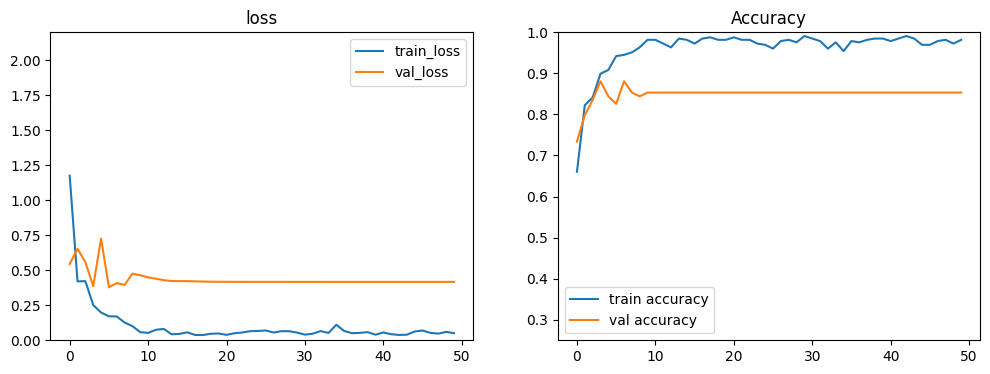

In [16]:
plot_history(history)

In [17]:
def model_evaluate(model, X, y):
  score= model.evaluate(X, y)[1]
  return f'Test score= {score:.2f}'

In [18]:
model_evaluate(model, X_test_preproc, y_test)

4/4 [==============================] - 7s 809ms/step - loss: 0.3961 - accuracy: 0.8818


'Test score= 0.88'

In [19]:
model_path= '/content/drive/My Drive/Colab Notebooks/Matuschkalulu/traffic_signs/models/improved_model.h5'
model.save(model_path)

## **Model_Testing**

In [20]:
from tensorflow import keras
from sklearn.metrics import classification_report

In [21]:
y_test= y_test.astype(int)


In [22]:
#model_path= '/content/drive/My Drive/Colab Notebooks/Matuschkalulu/traffic_signs/models/improved_model.h5'
y_pred= model.predict(X_test_preproc)
y_pred= y_pred.astype(int)
target_names=['class_0', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

4/4 [==============================] - 1s 145ms/step
              precision    recall  f1-score   support

     class_0       0.61      1.00      0.75        63
     class_1       1.00      0.13      0.23        47

    accuracy                           0.63       110
   macro avg       0.80      0.56      0.49       110
weighted avg       0.77      0.63      0.53       110



In [ ]:
y_pred= model.predict(X_test_preproc)

In [ ]:
target_names=['class_0', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))